In [25]:
import tensorflow as tf
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

tf.reset_default_graph()
seq_length = 2
data_dim = 3 # variable 갯수
hidden_dim = 2
output_dim = 2
learning_rate = 0.01
epoch_num = 10000

#위, 경도
t_time = 13
langtitude = 44
longtitude = 55

# factor
wind_direction = 11
water_temp = 11
wind_power = 33

factor = np.array([[wind_direction, water_temp, wind_power], [22,22,55], [44,33,66], [66,44,88]])
typhoon_name1 = np.array([[langtitude, longtitude]
                          ,[13, 22], [44, 55], [66, 88]])

#제일 앞이 뒤로, 제일 뒤가 앞으로
fac_rev = factor[::-1]
xy = typhoon_name1[::-1]
print("xy[0][0] : ",xy[0][0])
print("xy : ",xy)

x = xy
print("x[0] : ", x[0])
y = xy
print("y[0] : ", y[0])


xy[0][0] :  66
xy :  [[66 88]
 [44 55]
 [13 22]
 [44 55]]
x[0] :  [66 88]
y[0] :  [66 88]


route :  66 88
factor :  66 44 88
route :  44 55
factor :  44 33 66
route :  13 22
factor :  22 22 55
route :  44 55
factor :  11 11 33


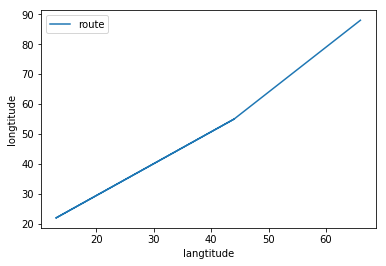

In [13]:
#데이터 시각화
plt.xlabel('langtitude') #위도
plt.ylabel('longtitude') #경도
graph_x = []
graph_y = []
fac_wind_dir = []
fac_water = []
fac_wind_pow = []

for i in range(4):
    graph_x.append(y[i][0])
    graph_y.append(y[i][1])
    fac_wind_dir.append(fac_rev[i][0])
    fac_water.append(fac_rev[i][1])
    fac_wind_pow.append(fac_rev[i][2])
    print("route : ", y[i][0], y[i][1])
    print("factor : ", fac_rev[i][0], fac_rev[i][1], fac_rev[i][2])

plt.plot(graph_x, graph_y)
plt.legend(['route'])


In [14]:
dataX=[]
dataY=[]

for i in range(0, len(y) - seq_length):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length][0:2] #다음 경로(정답)
    if i is 0:
        print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)


[[66 88]
 [44 55]] -> [13 22]


In [15]:
#학습용/ 테스트용 데이터 설정
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [27]:
#place holder 생성
X = tf.placeholder(tf.float32, [None, None, 3])
print("X : ", X)
Y = tf.placeholder(tf.float32, [None, 2])
print("Y : ", Y)
W = tf.placeholder(tf.float32, [None, 3]);
print("W : ", W)

X = [[fac_rev]]
print(X)

targets = tf.placeholder(tf.float32, [None, 2])
print("targets : ", targets)
predictions = tf.placeholder(tf.float32, [None, 2])
print("predictions : ", predictions)

X :  Tensor("Placeholder:0", shape=(?, ?, 3), dtype=float32)
Y :  Tensor("Placeholder_1:0", shape=(?, 2), dtype=float32)
W :  Tensor("Placeholder_2:0", shape=(?, 3), dtype=float32)
[[array([[66, 44, 88],
       [44, 33, 66],
       [22, 22, 55],
       [11, 11, 33]])]]
targets :  Tensor("Placeholder_3:0", shape=(?, 2), dtype=float32)
predictions :  Tensor("Placeholder_4:0", shape=(?, 2), dtype=float32)


In [23]:
#LSTM 생성
def lstm_cell() :
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, forget_bias = 0.8, state_is_tuple = True, activation = tf.tanh)
    return cell


In [26]:
#stacked rnn 생성
multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(1)], state_is_tuple = True)

# LSTM셀들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

ValueError: Shape (3, 4) must have rank at least 3

In [9]:
Y_pred = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_dim, activation_fn=None)

loss = tf.reduce_sum(tf.square(Y_pred - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
       
    # 학습한다
    for epoch in range(epoch_num):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {} loss: {}".format(epoch, step_loss),"]")
    
    # 테스트한다
    test_predict = sess.run(Y_pred, feed_dict={X: testX})

    print(test_predict)
    
    # 테스트용 데이터 기준으로 측정지표 rmse를 산출한다
    rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
    print("rmse: ", rmse_val)
    
    

NameError: name 'hypothesis' is not defined